<image src="https://raw.githubusercontent.com/semilleroCV/deep-learning-notes/main/assets/banner-notebook.png" width=100%>

# <font color='#4C5FDA'> **Segmentación de los objetos en la escena** </font>

La clasificación de imágenes da una <font color="EB9A54">**respuesta discreta etiquetada (dimensión de la imagen)** </font> a partir de una imagen de entrada con <font color="EB9A54">**objetos de interés**</font> en una escena concreta. Esta tarea es mucho más compleja, ya que incluye la localización, la detección y la delimitación espacial de los objetos.

Para la <font color="EB9A54">**segmentación semántica**</font> específicamente la tarea se asocia <font color="EB9A54">**a cada píxel**</font> con una etiqueta semántica producida por un algoritmo de aprendizaje automático. Esta tarea se conoce como <font color="EB9A54">**predicción densa**</font> y el resultado es útil para muchos escenarios, áreas y aplicaciones diferentes.

Durante este notebook vamos a explorar la segmentación de objetos en las escenas proveniente de conjuntos de datos sobre <font color="EB9A54">**vehículos autonomos**. </font>

In [1]:
!pip install transformers torch datasets matplotlib scikit-learn opencv-python

## <font color='#4C5FDA'>**Mask2Former: Modelo pre-entrenado**</font> <a name="tema1">

El modelo Mask2Former fue propuesto en Masked-attention Mask Transformer for Universal Image Segmentation por Bowen Cheng, Ishan Misra, Alexander G. Schwing, Alexander Kirillov, Rohit Girdhar. Mask2Former es un marco unificado para la segmentación panóptica, de instancia y semántica y presenta mejoras significativas de rendimiento y eficiencia respecto a MaskFormer.

<div align="center"> <image src="https://i.ibb.co/x6z1Qmj/mask2former-architecture.jpg" width=600>  </div>

In [11]:
#@title Librerías
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image
import torch
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import numpy as np

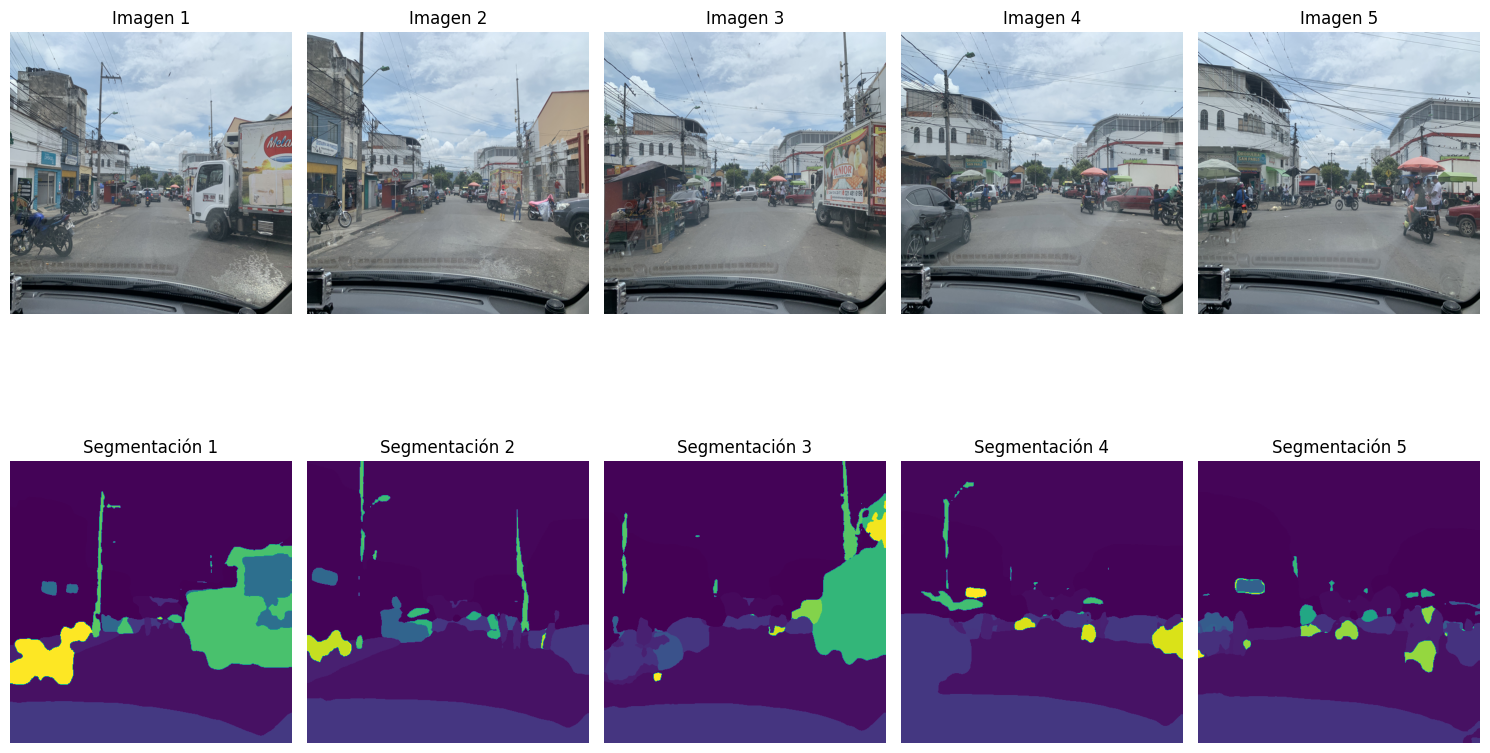

In [19]:
# Cargar el procesador y modelo Mask2Former preentrenado en ADE20k
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-ade-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-ade-semantic")

# Lista de URLs crudas de imágenes (enlaces directos de GitHub)
image_urls = [
    "https://raw.githubusercontent.com/semilleroCV/autonomous-navigation/main/data/BucaraSet/barrio-la-universidad/img/IMG_170.jpg",
    "https://raw.githubusercontent.com/semilleroCV/autonomous-navigation/main/data/BucaraSet/barrio-la-universidad/img/IMG_171.jpg",
    "https://raw.githubusercontent.com/semilleroCV/autonomous-navigation/main/data/BucaraSet/barrio-la-universidad/img/IMG_172.jpg",
    "https://raw.githubusercontent.com/semilleroCV/autonomous-navigation/main/data/BucaraSet/barrio-la-universidad/img/IMG_173.jpg",
    "https://raw.githubusercontent.com/semilleroCV/autonomous-navigation/main/data/BucaraSet/barrio-la-universidad/img/IMG_174.jpg"
]

# Función para procesar y mostrar imagen + segmentación
def process_and_show_images(image_urls):
    # Crear un número adecuado de filas y columnas
    num_images = len(image_urls)
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5 * 2))

    for i, image_url in enumerate(image_urls):
        try:
            # Descargar la imagen desde la URL
            response = requests.get(image_url, stream=True)
            response.raise_for_status()  # Verificar que la solicitud sea exitosa
            image = Image.open(BytesIO(response.content)).convert("RGB")

            # Reescalar las imágenes para que se ajusten mejor al espacio
            image_resized = image.resize((512, 512))

            # Preprocesar la imagen
            inputs = image_processor(images=image_resized, return_tensors="pt")

            # Realizar la inferencia (sin calcular gradientes)
            with torch.no_grad():
                outputs = model(**inputs)

            # Obtener el mapa de segmentación semántica
            pred_semantic_map = image_processor.post_process_semantic_segmentation(
                outputs, target_sizes=[image_resized.size[::-1]]
            )[0]

            # Convertir el tensor de segmentación a un array de Numpy
            pred_semantic_map = pred_semantic_map.detach().cpu().numpy()

            # Convertir el array de Numpy a una imagen de PIL
            pred_semantic_map_resized = Image.fromarray(pred_semantic_map.astype(np.uint8))

            # Reescalar la segmentación para que tenga el mismo tamaño que la imagen
            pred_semantic_map_resized = pred_semantic_map_resized.resize((512, 512))

            # Mostrar la imagen original en la primera fila
            axes[0, i].imshow(image_resized)
            axes[0, i].set_title(f"Imagen {i+1}")
            axes[0, i].axis("off")

            # Mostrar la segmentación en la segunda fila
            axes[1, i].imshow(pred_semantic_map_resized)
            axes[1, i].set_title(f"Segmentación {i+1}")
            axes[1, i].axis("off")

        except requests.exceptions.RequestException as e:
            print(f"Error al descargar la imagen: {e}")
        except Exception as e:
            print(f"Error al procesar la imagen {image_url}: {e}")

    plt.tight_layout()
    plt.show()

# Procesar imágenes desde las URLs directas
process_and_show_images(image_urls)

## <font color='#4C5FDA'>**Aprendizaje supervisado: U-Net**</font> <a name="tema2">

El aprendizaje supervisado es una rama del aprendizaje automático donde un modelo se entrena utilizando un <font color="EB9A54">**conjunto de datos etiquetados.**</font> Estos datos etiquetados contienen ejemplos de entradas y sus salidas deseadas (etiquetas). El objetivo es que el modelo aprenda a mapear las entradas a las salidas correctas y pueda generalizar para predecir la salida para nuevas entradas no vistas durante el entrenamiento.

<div align="center">
<img src="https://i.ibb.co/2Pqdgtb/unet.png" width=60%> </div>

## <font color='#4C5FDA'>**Aprendizaje semi-supervisado**</font> <a name="tema2">

El aprendizaje semi-supervisado es una técnica de aprendizaje automático que combina elementos del aprendizaje supervisado y no supervisado. En este enfoque, el modelo se entrena utilizando un conjunto de datos que contiene tanto <font color="EB9A54">**datos etiquetados como no etiquetados.**</font> La idea principal es aprovechar la información presente en los datos no etiquetados para mejorar el rendimiento del modelo.

